In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from hydra import initialize, compose

import time

import torch
from torch import optim

from bliss.models import encoder, decoder
from bliss.models.encoder import get_star_bool
from bliss.datasets import simulated

import sys
sys.path.insert(0, './utils/')
import plotting_utils 
import flux_encoder_lib
from flux_loss_lib import kl_qp_flux_loss


from which_device import device
print(device)


# _ = torch.manual_seed(34)


cuda:4


# Load dataset

In [2]:
overrides = {'model':"sleep_sdss_measure_simple", 'dataset':'default'}
overrides = [f"{key}={value}" for key, value in overrides.items()]
with initialize(config_path="../../config"): # possibly change relative path to config folder here. 
    cfg = compose("config", overrides=overrides)

In [3]:
# overwriting some values 
cfg.dataset.kwargs.update({'generate_device': device,
                           'n_batches': 500})


# some simplifications for debugging
cfg.model.kwargs.decoder_kwargs.update({'prob_galaxy': 0., 
                                        'min_sources': 1, 
                                        'max_sources': 1, 
                                        'ptile_slen': 10, 
                                        'tile_slen': 2,
                                        'border_padding': 4
                                        })

cfg.model.image.update({'slen': 2})

In [4]:
dataset = simulated.SimulatedDataset(**cfg.dataset.kwargs)

# save some constants we will use later
slen = dataset.image_decoder.slen
n_bands = dataset.image_decoder.n_bands

tile_slen = dataset.image_decoder.tile_slen
ptile_slen = dataset.image_decoder.ptile_slen

batch_size = dataset.batch_size
border_padding = dataset.image_decoder.border_padding
max_sources = dataset.image_decoder.max_sources

# we will need the decoder later for the loss as well 
image_decoder = dataset.image_decoder
image_decoder.requires_grad_(False);

### The data loaders

In [5]:
train_dataloader = dataset.train_dataloader()
test_dataloader = dataset.test_dataloader()

### some sample images

In [6]:
for _, batch in enumerate(train_dataloader):
    break

In [7]:
_true_tile_dict = dict(locs = batch['locs'],
                       n_sources = batch['n_sources'],
                       galaxy_bool = batch['galaxy_bool'])
    
true_params = encoder.get_full_params(_true_tile_dict, dataset.image_decoder.slen)


In [8]:
def plot_params(params, indx, ax): 
    locs = params['locs'][indx].cpu() * slen + border_padding - 0.5
    locs = locs[:, (1, 0)]

    n_sources = int(params['n_sources'][indx])
    galaxy_bool = params['galaxy_bool'][indx].squeeze(-1).cpu()    
    
    plotting_utils.plot_locations(locs, 
                                  galaxy_bool, 
                                  n = n_sources, 
                                  ax = ax)

In [9]:
%matplotlib inline

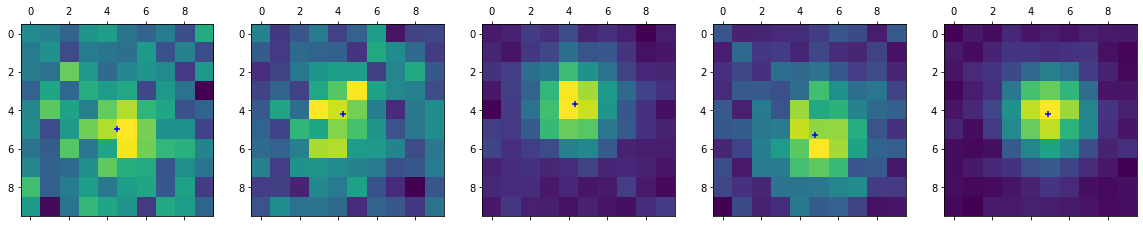

In [10]:
fig, axes = plt.subplots(1, 5, figsize=(20,5))

for indx in range(batch['images'].shape[0]):
    
    if indx > 4: 
        break
        
    # plot image 
    axes[indx].matshow(batch['images'][indx, 0].cpu())

    # plot parameters
    plot_params(true_params, indx, axes[indx])

# Define encoder

In [11]:
flux_encoder = flux_encoder_lib.MLPEncoder(ptile_slen = ptile_slen, 
                                           tile_slen = tile_slen,
                                           n_bands = n_bands,
                                           max_sources = max_sources).to(device)

# Define loss

In [12]:
def get_loss(batch): 
    
    # get estimates
    out = flux_encoder(batch['images'])
    
    # get loss
    kl, neg_ll, recon = kl_qp_flux_loss(image_decoder, 
                                  batch,
                                  out['samples'], 
                                  out['sd'])
        
    return kl.mean(), neg_ll.mean()

### This is the log-likelihood under the true parameters 

In [13]:
_, neg_ll, _ = \
    kl_qp_flux_loss(image_decoder, 
                    batch,
                    batch['fluxes'], 
                    # set the sd to 1
                    batch['fluxes'] * 0. + 1.0)

print('negative loglikelihood (truth): ', neg_ll.mean())

negative loglikelihood (truth):  tensor(487.7195, device='cuda:4')


# Train

In [14]:
# initial loss 
for _, test_batch in enumerate(test_dataloader):
    break
    
loss, neg_ll = get_loss(test_batch)

print('initial loss: {}'.format(loss))
print('initial NLL: {}'.format(neg_ll))

initial loss: 55640.7734375
initial NLL: 55633.0859375


In [15]:
# define optimizer 
n_epochs = 50

optimizer = optim.Adam(flux_encoder.parameters(), 
                       lr = 1e-3)


In [16]:
for epoch in range(n_epochs): 

    avg_loss = 0.
    counter = 0.

    for _, batch in enumerate(train_dataloader):

        optimizer.zero_grad()

        # evaluate loss
        loss, _ = get_loss(batch)

        loss.backward()

        optimizer.step()

        avg_loss += loss 
        counter += 1.

    print('epoch [{}]. loss = {}'.format(epoch, avg_loss / counter))


epoch [0]. loss = 21705.97265625
epoch [1]. loss = 4160.95703125
epoch [2]. loss = 886.8848266601562
epoch [3]. loss = 520.87255859375
epoch [4]. loss = 497.4621887207031
epoch [5]. loss = 496.2096862792969


KeyboardInterrupt: 

# Evaluate

In [17]:
# get estimates
out = flux_encoder(test_batch['images'])

# get loss
loss, neg_ll, recon = kl_qp_flux_loss(image_decoder, 
                              test_batch,
                              out['mean'], 
                              out['sd'])


print('final loss: {}'.format(loss.mean()))
print('final NLL: {}'.format(neg_ll.mean()))

final loss: 486.9439697265625
final NLL: 492.32183837890625


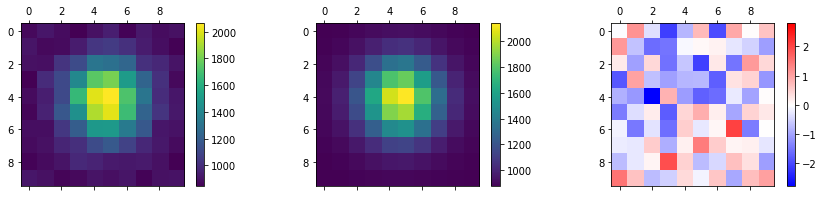

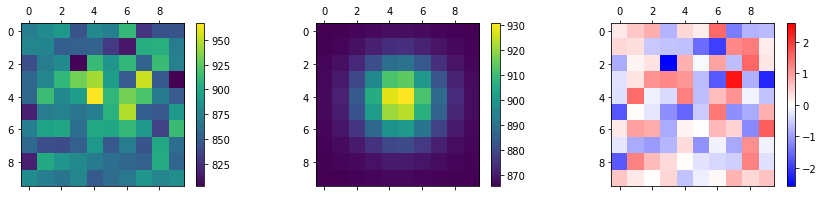

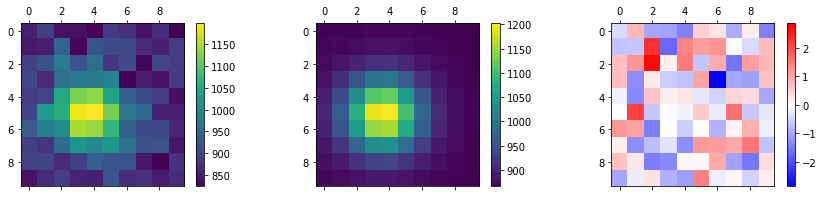

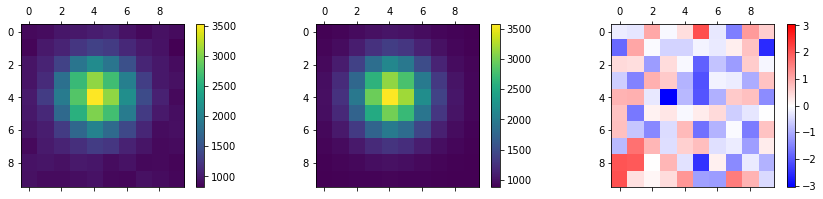

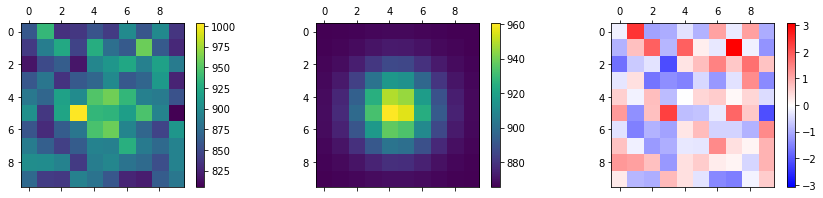

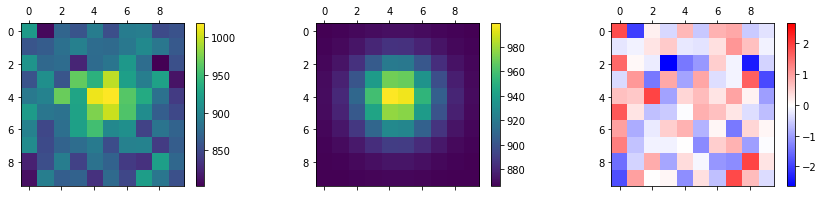

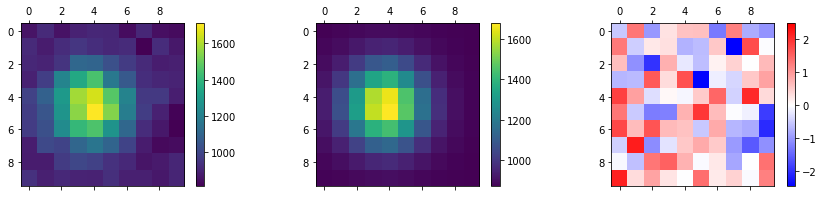

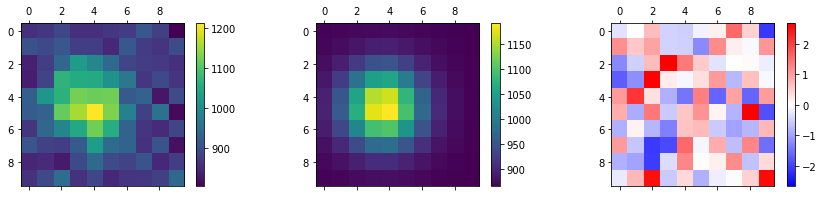

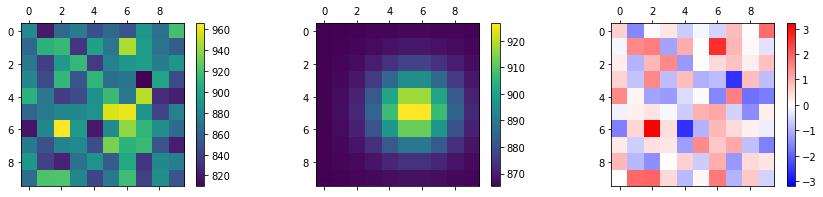

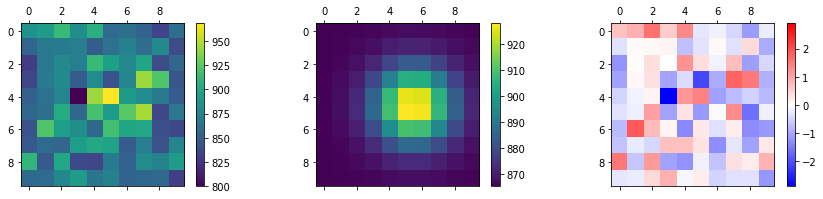

In [18]:
for indx in range(10):

    plotting_utils.plot_residuals(test_batch['images'][indx, 0], 
                                  recon[indx, 0], 
                                  resid_fun=lambda x, y : (x - y) / torch.sqrt(y))

In [19]:
is_star = get_star_bool(test_batch['n_sources'], test_batch['galaxy_bool']) == 1

truth = test_batch['fluxes'][is_star].cpu().numpy()
est = out['mean'][is_star].cpu().detach().numpy()

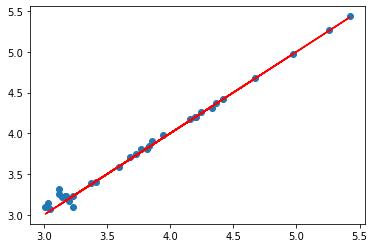

In [24]:
plt.scatter(np.log10(truth), 
            np.log10(est))

plt.plot(np.log10(truth), 
         np.log10(truth), 
         color = 'red')

(array([ 1.,  2.,  6., 10.,  4.,  7.,  0.,  1.,  0.,  1.]),
 array([-3.9416277 , -2.5874476 , -1.2332674 ,  0.12091277,  1.4750929 ,
         2.8292732 ,  4.183453  ,  5.5376334 ,  6.8918138 ,  8.245994  ,
         9.600174  ], dtype=float32),
 <BarContainer object of 10 artists>)

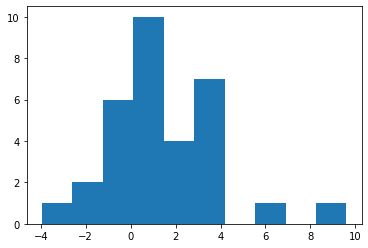

In [25]:
sd = out['sd'][is_star].cpu().detach().numpy()

zscores = (est - truth) / sd

plt.hist(zscores)